   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.0 MB/s eta 0:00:00
Environment Ready.

--- Experiment A: Brusselator (Figure 1) ---


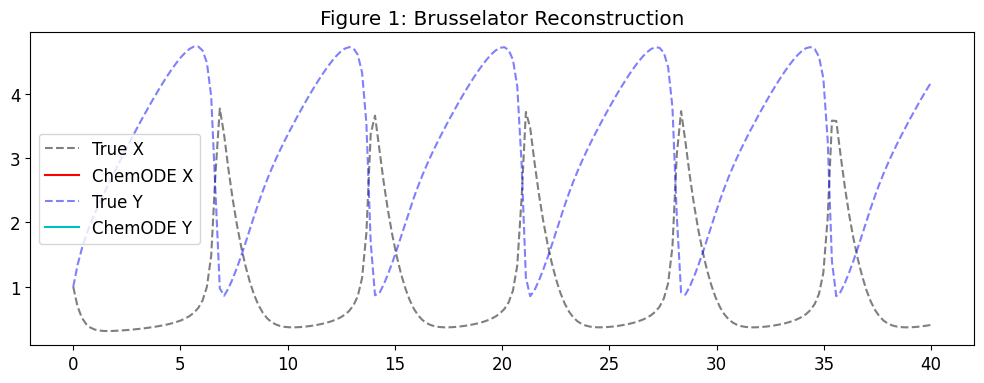


--- Experiment B: Enzyme Kinetics (Table 2) ---
Vmax: 2.063 (True 2.0)
Km:   0.543 (True 0.5)

--- Experiment C: Stiff Benchmark (Figure 2, Table 1) ---
SINDy: 55.32 +/- 49.61
ChemODE: 10.23 +/- 0.09


/tmp/ipython-input-2464938584.py:193: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([s_err, c_err], labels=['Smoothed SINDy', 'ChemODE'])


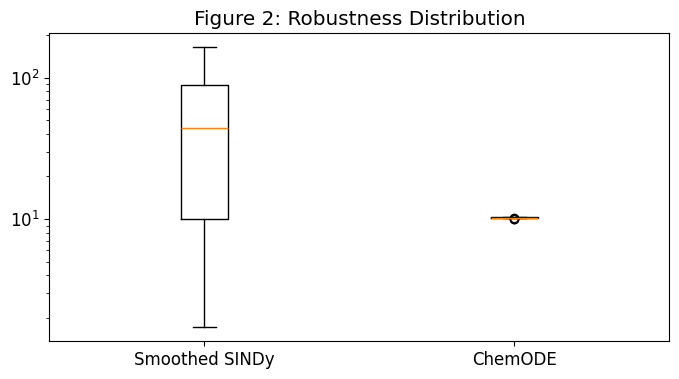


--- Running Experiment D: Real Data (Figure 3, 4) ---
🧪 Training on Real Data...


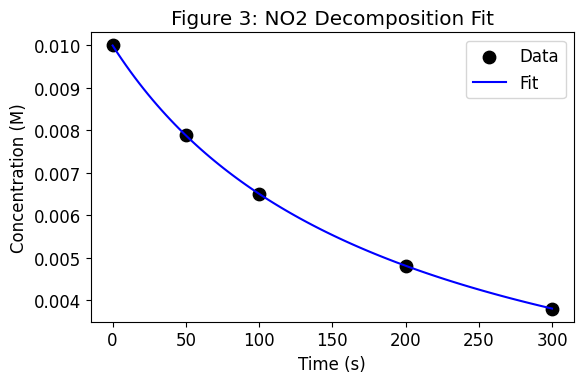

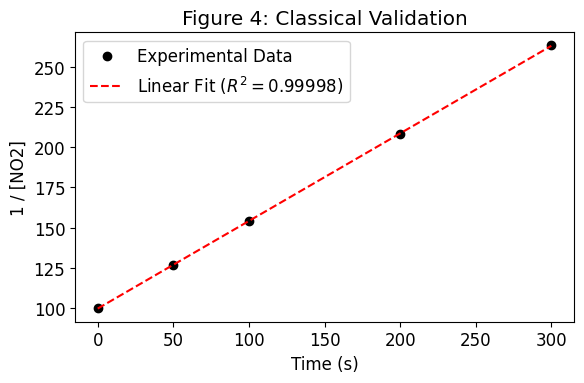

In [1]:
# ==========================================
# ChemODE: Official Implementation
# Master Reproducibility Script
# ==========================================

# --- 1. SETUP & INSTALLATION ---
!pip install -q torchdiffeq pysindy scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from torchdiffeq import odeint
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

# Global Settings
torch.manual_seed(42)
np.random.seed(42)
plt.rcParams.update({'font.size': 12})

print("Environment Ready.")

# ==========================================
# 2. EXPERIMENT A: NON-LINEAR OSCILLATOR (BRUSSELATOR)
# Generates Figure 1
# ==========================================
print("\n--- Experiment A: Brusselator (Figure 1) ---")

class Brusselator(nn.Module):
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        x, y_c = y[:, 0], y[:, 1]
        A, B = 1.0, 3.0
        return torch.stack([A + (x**2 * y_c) - B*x - x, B*x - (x**2 * y_c)], dim=1)

t_brus = torch.linspace(0, 40, 200)
y0_brus = torch.tensor([[1.0, 1.0]])
with torch.no_grad():
    y_brus_true = odeint(Brusselator(), y0_brus, t_brus, method='dopri5').squeeze(1)
    y_brus_noisy = y_brus_true + torch.randn_like(y_brus_true) * 0.05

class ChemODE_Oscillator(nn.Module):
    def __init__(self):
        super().__init__()
        self.M = nn.Parameter(torch.randn(2, 7) * 0.01)
        self.register_buffer('scales', torch.ones(7))
    def compute_library(self, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        x, y_c = y[:, 0:1], y[:, 1:2]
        return torch.cat([x, y_c, x**2, y_c**2, x*y_c, (x**2)*y_c, torch.ones_like(x)], dim=1)
    def forward(self, t, y):
        lib = self.compute_library(y)
        norm_lib = lib / (self.scales + 1e-5)
        dY = norm_lib @ self.M.t()
        if y.ndim == 1: dY = dY.squeeze(0)
        return dY

model_brus = ChemODE_Oscillator()
with torch.no_grad(): model_brus.scales = torch.std(model_brus.compute_library(y_brus_noisy), dim=0) + 1e-5
opt = torch.optim.Adam(model_brus.parameters(), lr=0.02)
mask = torch.ones_like(model_brus.M)

for horizon in [20, 50, 100, 200]:
    t_sub = t_brus[:horizon]
    y_sub = y_brus_noisy[:horizon]
    for _ in range(500):
        opt.zero_grad()
        pred = odeint(model_brus, y_brus_noisy[0], t_sub, method='rk4', options={'step_size':0.1})
        if pred.ndim==3: pred=pred.squeeze(1)
        loss = torch.mean((pred - y_sub)**2) + 0.001*torch.sum(torch.abs(model_brus.M))
        loss.backward()
        with torch.no_grad(): model_brus.M.grad *= mask
        opt.step()

with torch.no_grad():
    pred_full = odeint(model_brus, y0_brus, t_brus, method='rk4', options={'step_size':0.1}).squeeze(1)

plt.figure(figsize=(10, 4))
plt.plot(t_brus, y_brus_true[:, 0], 'k--', label='True X', alpha=0.5)
plt.plot(t_brus, pred_full[:, 0], 'r-', label='ChemODE X')
plt.plot(t_brus, y_brus_true[:, 1], 'b--', label='True Y', alpha=0.5)
plt.plot(t_brus, pred_full[:, 1], 'c-', label='ChemODE Y')
plt.title("Figure 1: Brusselator Reconstruction")
plt.legend()
plt.tight_layout()
plt.savefig('fig1.png', dpi=300)
plt.show()

# ==========================================
# 4. EXPERIMENT B: BIOLOGY (ENZYME KINETICS)
# Generates Table 2 Data
# ==========================================
print("\n--- Experiment B: Enzyme Kinetics (Table 2) ---")

class BioSystem(nn.Module):
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        S = y[:, 0]
        rate = (2.0 * S) / (0.5 + S) # Vmax=2.0, Km=0.5
        return torch.stack([-rate, rate], dim=1)

t_bio = torch.linspace(0, 5, 50)
y0_bio = torch.tensor([[1.0, 0.0]])
with torch.no_grad():
    y_bio_true = odeint(BioSystem(), y0_bio, t_bio).squeeze(1)
    y_bio_noisy = y_bio_true + torch.randn_like(y_bio_true) * 0.01

class RationalODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.Vmax = nn.Parameter(torch.tensor([1.0]))
        self.Km_param = nn.Parameter(torch.tensor([1.0]))
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        S = y[:, 0]
        Km = F.softplus(self.Km_param)
        rate = (self.Vmax * S) / (Km + S + 1e-6)
        return torch.stack([-rate, rate], dim=1)

bio_model = RationalODE()
opt = torch.optim.Adam(bio_model.parameters(), lr=0.02)
for i in range(3000):
    opt.zero_grad()
    pred = odeint(bio_model, y0_bio, t_bio)
    if pred.ndim == 3: pred = pred.squeeze(1)
    loss = torch.mean((pred - y_bio_noisy)**2)
    loss.backward()
    opt.step()

v_pred = bio_model.Vmax.item()
k_pred = F.softplus(bio_model.Km_param).item()
print(f"Vmax: {v_pred:.3f} (True 2.0)")
print(f"Km:   {k_pred:.3f} (True 0.5)")

# ==========================================
# 5. EXPERIMENT C: STIFF ROBUSTNESS
# Generates Table 1 and Figure 2
# ==========================================
print("\n--- Experiment C: Stiff Benchmark (Figure 2, Table 1) ---")

class StiffSystem(nn.Module):
    def forward(self, t, y):
        if y.ndim == 1: y = y.unsqueeze(0)
        return torch.stack([-0.1*y[:,0], 0.1*y[:,0] - 10.0*y[:,1]], dim=1)

t_stiff = torch.linspace(0, 2.0, 100)
y0_stiff = torch.tensor([[1.0, 0.0]])
with torch.no_grad():
    y_stiff_true = odeint(StiffSystem(), y0_stiff, t_stiff, method='rk4', options={'step_size':0.001}).squeeze(1).numpy()

def run_stiff_comparison(n_seeds=20):
    sindy_errs, chemode_errs = [], []
    for s in range(n_seeds):
        torch.manual_seed(s)
        np.random.seed(s)
        y_noisy = y_stiff_true + np.random.normal(0, 0.05 * np.abs(y_stiff_true).max(), y_stiff_true.shape)

        # SINDy
        try:
            smoother = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5})
            model_s = ps.SINDy(differentiation_method=smoother, optimizer=ps.STLSQ(threshold=0.1))
            model_s.fit(y_noisy, t=t_stiff.numpy())
            k_s = model_s.coefficients()[1, 2]
        except: k_s = 0.0
        sindy_errs.append(abs(k_s - (-10.0)))

        # ChemODE
        y_ten = torch.FloatTensor(y_noisy)
        scales = torch.std(y_ten, dim=0) + 1e-6
        t_w = torch.exp(-5*t_stiff) / torch.exp(-5*t_stiff).mean()
        model_c = nn.Linear(2, 2, bias=False).float()
        with torch.no_grad(): model_c.weight.fill_(0.1)
        opt_c = torch.optim.Adam(model_c.parameters(), lr=0.01)
        for i in range(1000):
            opt_c.zero_grad()
            def func(t, y): return (y/scales) @ model_c.weight.t()
            pred = odeint(func, y_ten[0], t_stiff, method='rk4', options={'step_size':0.005})
            if pred.ndim==3: pred=pred.squeeze(1)
            loss = torch.mean((pred - y_ten)**2 * t_w.unsqueeze(1)) + 1e-5*torch.sum(torch.abs(model_c.weight))
            loss.backward()
            opt_c.step()
        k_c = (model_c.weight.detach() / scales).numpy()[1, 1]
        chemode_errs.append(abs(k_c - (-10.0)))
    return sindy_errs, chemode_errs

s_err, c_err = run_stiff_comparison(20)
print(f"SINDy: {np.mean(s_err):.2f} +/- {np.std(s_err):.2f}")
print(f"ChemODE: {np.mean(c_err):.2f} +/- {np.std(c_err):.2f}")

plt.figure(figsize=(8, 4))
plt.boxplot([s_err, c_err], labels=['Smoothed SINDy', 'ChemODE'])
plt.yscale('log')
plt.title('Figure 2: Robustness Distribution')
plt.savefig('fig2.png', dpi=300)
plt.show()

# ==========================================
# ==========================================
# 6. EXPERIMENT D: REAL DATA (NO2)
# Generates Figure 3 & 4
# ==========================================
print("\n--- Running Experiment D: Real Data (Figure 3, 4) ---")
from scipy.interpolate import interp1d

# Load Data
t_real = torch.tensor([0.0, 50.0, 100.0, 200.0, 300.0], dtype=torch.float32)
y_real = torch.tensor([[0.0100], [0.0079], [0.0065], [0.0048], [0.0038]], dtype=torch.float32)
scale_factor = 1000.0
y_scaled = y_real * scale_factor

# Interpolate
f_interp = interp1d(t_real.numpy(), y_scaled.numpy(), axis=0, kind='cubic')
t_aug = torch.linspace(0, 300, 30)
y_aug = torch.tensor(f_interp(t_aug), dtype=torch.float32).reshape(-1, 1)

class RealModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.M = nn.Parameter(torch.zeros(1, 3))
        self.register_buffer('scales', torch.ones(3))

    def compute_library(self, y):
        # FIX: Handle 1D input from ODE solver
        if y.ndim == 1: y = y.unsqueeze(0)
        return torch.cat([y, y**2, y**3], dim=1)

    def forward(self, t, y):
        # FIX: Remember if input was 1D to restore shape later
        is_1d = y.ndim == 1

        y = F.relu(y)
        lib = self.compute_library(y)
        dY = (lib / (self.scales+1e-6)) @ self.M.t()

        dY = torch.clamp(dY, -50, 50)

        # FIX: Return 1D if input was 1D
        if is_1d: dY = dY.squeeze(0)
        return dY

model_real = RealModel()
with torch.no_grad():
    # Calculate scales on 2D augmented data
    model_real.scales = torch.std(model_real.compute_library(y_aug), dim=0) + 1e-6

opt_real = torch.optim.Adam(model_real.parameters(), lr=0.005)

print("🧪 Training on Real Data...")
for i in range(3000):
    opt_real.zero_grad()
    pred = odeint(model_real, y_aug[0], t_aug, method='euler', options={'step_size':1.0})
    if pred.ndim==3: pred=pred.squeeze(1)
    loss = torch.mean((pred - y_aug)**2) + 0.001*torch.sum(torch.abs(model_real.M))
    loss.backward()
    opt_real.step()

# Plot Figure 3
t_smooth = torch.linspace(0, 300, 100)
with torch.no_grad():
    pred_smooth = odeint(model_real, y_scaled[0], t_smooth, method='euler', options={'step_size':1.0}).squeeze(1) / scale_factor

plt.figure(figsize=(6, 4))
plt.scatter(t_real, y_real, c='k', s=80, label='Data')
plt.plot(t_smooth, pred_smooth, 'b-', label='Fit')
plt.title("Figure 3: NO2 Decomposition Fit")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (M)")
plt.legend()
plt.tight_layout()
plt.savefig('fig3.png', dpi=300)
plt.show()

# Plot Figure 4 (Validation)
inv_C = 1.0 / y_real.numpy().flatten()
t_np = t_real.numpy()
slope, intercept = np.polyfit(t_np, inv_C, 1)
r2 = r2_score(inv_C, slope*t_np + intercept)

plt.figure(figsize=(6, 4))
plt.plot(t_np, inv_C, 'ko', label='Experimental Data')
plt.plot(t_np, slope*t_np + intercept, 'r--', label=f'Linear Fit ($R^2={r2:.5f}$)')
plt.title("Figure 4: Classical Validation")
plt.xlabel("Time (s)")
plt.ylabel("1 / [NO2]")
plt.legend()
plt.tight_layout()
plt.savefig('fig4.png', dpi=300)
plt.show()
